In [1]:
from typing import TypedDict, Annotated, Optional, List
from pydantic import BaseModel, Field
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

load_dotenv()

# llm = ChatGroq(model="llama-3.1-8b-instant")



True

In [2]:
search_tool = TavilySearch(max_results=5)
tools = [search_tool]
memory = MemorySaver()

In [3]:
llm_with_tools = llm.bind_tools(tools)

In [4]:
from typing import Literal
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage


class State(TypedDict):
    messages: Annotated[List, add_messages]


async def model(state: State) -> State:
    """
    Model function that processes the state and returns it.
    """
    # Convert messages to a format suitable for the LLM
    messages = state['messages']

    # Invoke the LLM with the messages
    response = await llm_with_tools.ainvoke(messages)

    return {
        "messages": [response]
    }


async def tool_router(state: State):
    """
    Tool router function that processes the state and returns it.
    """
    messages = state['messages']
    last_message = messages[-1] if messages else None
    # Check if the last message is a ToolMessage
    if last_message and hasattr(last_message, 'tool_calls') and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END


async def tool_node(state: State):
    """
    Tool node function that processes the state and returns it.
    """
    tool_calls = state['messages'][-1].tool_calls
    if not tool_calls:
        return state
    # Process each tool call
    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name == "tavily_search":
            # Call the Tavily search tool
            search_results = await search_tool.ainvoke(tool_args)
            print(f"Search results: {search_results}")
            # Create a ToolMessage with the search results
            tool_message = ToolMessage(
                content=str(search_results),
                name=tool_name,
                tool_call_id=tool_id,
            )
            tool_messages.append(tool_message)
    return {
        "messages": tool_messages
    }

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)

graph_builder.set_entry_point("model")
graph_builder.add_conditional_edges("model", tool_router, path_map={
    "tool_node": "tool_node",
    END: END
})
graph_builder.add_edge("tool_node", "model")


graph = graph_builder.compile(checkpointer=memory)

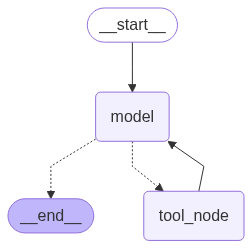

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
from langchain_core.runnables import RunnableConfig

thread_config = RunnableConfig(
    {"configurable": {
        "thread_id": 11,
    }}
)

response = graph.ainvoke({
    "messages": [
        HumanMessage(
            content="what are the top headlines in Nigeria News today"),
    ]
}, config=thread_config)
response

<coroutine object Pregel.ainvoke at 0x7fdba918a430>

In [7]:
thread_config = RunnableConfig(
    {"configurable": {
        "thread_id": 15,
    }}
)

events = graph.astream_events({
    "messages": [
        HumanMessage(
            content="what are the top headlines in Nigeria News today "),
    ]
}, config=thread_config, version="v2")

async for event in events:
    print(event)  # Print the event for debugging purposes
    if event["event"] == "on_chat_model_stream":
        if "chunk" in event["data"]:
            # Print the content of the chunk
            print(event["data"]["chunk"].content, end="", flush=True)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what are the top headlines in Nigeria News today ', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1764bb19-de72-4788-9880-610897e77e94', 'metadata': {'thread_id': 15}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what are the top headlines in Nigeria News today ', additional_kwargs={}, response_metadata={}, id='491eddd3-1a0f-481f-925e-180141d8463c')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '52cac132-5f3a-4984-8d5b-6750d5106eb0', 'metadata': {'thread_id': 15, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:a79e83c2-548a-21d2-7db1-cc9e52296f32'}, 'parent_ids': ['1764bb19-de72-4788-9880-610897e77e94']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[Huma